In [1]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [2]:
# constant
epochs = 5
batch_size = 64
lr = 0.001

In [3]:
# 加载数据
train_loader = DataLoader(torchvision.datasets.MNIST('./data/',train=True,download=True,
                                                     transform=torchvision.transforms.Compose([
                                                         torchvision.transforms.ToTensor(),
                                                         torchvision.transforms.Normalize((0.1307,),(0.3081,))
                                                     ])),batch_size=batch_size,shuffle=True)
test_loader = DataLoader(torchvision.datasets.MNIST('./data/',train=False,download=True,
                                                     transform=torchvision.transforms.Compose([
                                                         torchvision.transforms.ToTensor(),
                                                         torchvision.transforms.Normalize((0.1307,),(0.3081,))
                                                     ])),batch_size=batch_size,shuffle=True)

torch.Size([1, 28, 28])
真实值： tensor(7)



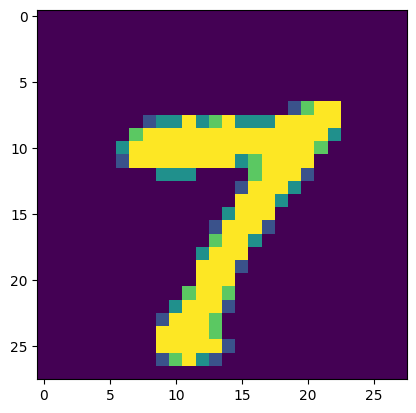

In [4]:
def display_a_array(pic):
    plt.imshow(np.array(pic.reshape(28,28)))
    plt.show()
pic_data = next(iter(train_loader))
pic = pic_data[0][0]
label = pic_data[1][0]
print(pic.shape)
print("真实值：",label)
print()
display_a_array(pic)

In [5]:
# 定义网络
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Conv2d(1,10,kernel_size=3,padding=1) #28 28 10
        self.pool1 = nn.MaxPool2d(kernel_size=2)               #14 14 10
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(10,20,kernel_size=3,padding=1)   #14 14 20
        self.conv2_drop = nn.Dropout2d()
        self.pool2 = nn.MaxPool2d(kernel_size=2)                #7 7 20
        self.conv3 = nn.Conv2d(20,10,kernel_size=1)             #7 7 10
        self.relu2 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(490,100)                           #7*7*10 = 490
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(100,10)
        self.softmax = nn.Softmax(dim=1)
    def forward(self,x):
        h = self.conv1(x)
        h = self.pool1(h)
        h = self.relu1(h)
        h = self.conv2(h)
        h = self.conv2_drop(h)
        h = self.pool2(h)
        h = self.conv3(h)
        h = self.relu2(h)
        h = self.flatten(h)
        h = self.fc1(h)
        h = self.relu3(h)
        h = self.fc2(h)
        return self.softmax(h)

In [6]:
def evaluate_accuracy(net,data_iter):
    net.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for X, y in data_iter:
            y_hat = net(X)
            _,prediction = torch.max(y_hat,1)
            total =  total + y.size(0)
            correct = correct + (prediction == y).sum().item()
    return correct,total,100.0*correct/total
        

In [7]:
net = Net()
optimizer = optim.Adam(net.parameters(),lr=lr)
loss = nn.CrossEntropyLoss()
train_loss = []
train_acc = []
test_acc = []

In [47]:
def train_one_epoch(epoch):
    net.train()
    runing_loss = 0
    correct = 0
    total = 0
    for batch_idx,(X,y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_hat = net(X)  
        l = loss(y_hat,y)
        l.backward()
        optimizer.step()

        runing_loss += l.item()
        if batch_idx%100 == 99:
            print(f'epoch:{epoch+1},batch_idx:{batch_idx+1},running_loss:{runing_loss/100}')
            runing_loss = 0
        train_loss.append(l.item())

        
        _,prediction = torch.max(y_hat,1)
        total += y.size(0)
        correct += (prediction == y).sum().item()
    train_acc.append(100*correct/total)
for epoch in range(epochs):
    train_one_epoch(epoch)
    test_acc.append(evaluate_accuracy(net,test_loader)[2])
    print(f'###epoch:{epoch+1},train_loss:{train_loss[-1]},train_acc:{train_acc[-1]},test_acc:{test_acc[-1]}')

epoch:1,batch_idx:100,running_loss:2.0509841990470887
epoch:1,batch_idx:200,running_loss:1.6388540053367615
epoch:1,batch_idx:300,running_loss:1.5813642847537994
epoch:1,batch_idx:400,running_loss:1.5554297471046448
epoch:1,batch_idx:500,running_loss:1.5471946048736571
epoch:1,batch_idx:600,running_loss:1.5426611280441285
epoch:1,batch_idx:700,running_loss:1.535178586244583
epoch:1,batch_idx:800,running_loss:1.5287524628639222
epoch:1,batch_idx:900,running_loss:1.5269132137298584
###epoch:1,train_loss:1.5051910877227783,train_acc:96.875,test_acc:94.37
epoch:2,batch_idx:100,running_loss:1.5265715420246124
epoch:2,batch_idx:200,running_loss:1.524893548488617
epoch:2,batch_idx:300,running_loss:1.5253480887413025
epoch:2,batch_idx:400,running_loss:1.5206361198425293
epoch:2,batch_idx:500,running_loss:1.5208510196208953
epoch:2,batch_idx:600,running_loss:1.5186925220489502
epoch:2,batch_idx:700,running_loss:1.5141627061367036
epoch:2,batch_idx:800,running_loss:1.5115256702899933
epoch:2,bat

In [44]:
a,b,c = evaluate_accuracy(net,train_loader)
print(a,b,c)
a,b,c = evaluate_accuracy(net,test_loader)
print(a,b,c)

58281 60000 97.135
9705 10000 97.05


In [49]:
def save_net(path = 'mnist.pt', net=None):
    torch.save(net.state_dict(),path)
save_net('epoch5,lr0,01-2.pt',net)

In [17]:
def load_net(path='mnist.pt',net=None):
    net.load_state_dict(torch.load(path))
load_net('epoch5,lr0,01.pt',net)

In [9]:
from PIL import Image
def load_a_image(path):
    img = Image.open(path)
    img = img.convert('L')
    img = np.array(img,dtype=np.uint8)
    return img
load_a_image('./number.png')

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

预测数字:4


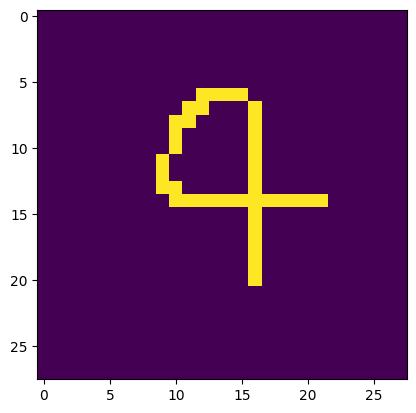

In [18]:
#预测
def predict_a_image(path,net):
    img = load_a_image(path)
    net.eval()
    y_hat = net(torch.tensor(np.array(img.reshape(1,1,28,28),dtype=np.float32)))
    _,prediction = torch.max(y_hat,1)
    print(f'预测数字:{prediction.item()}')
    plt.imshow(img)
    plt.show()
predict_a_image('./number.png',net)


预测数字：5,真实数字：5


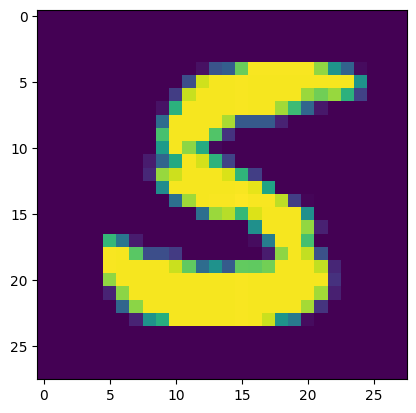

预测数字：7,真实数字：7


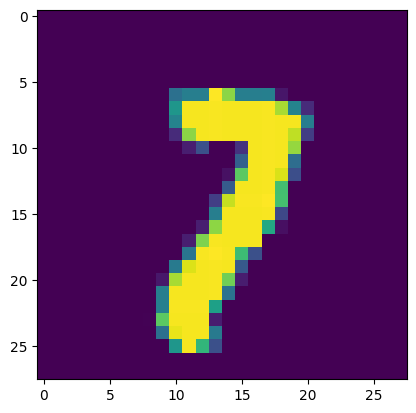

In [19]:
def predict_test_case(data_loader,net):
    for batch_idx,(X, y) in enumerate(data_loader):
        net.eval()
        y_hat = net(X)
        _,predict = torch.max(y_hat,1)
        print(f'预测数字：{predict[0]},真实数字：{y[0]}')
        plt.imshow(np.array(X[0].reshape(28,28)))
        plt.show()
        print(f'预测数字：{predict[1]},真实数字：{y[1]}')
        plt.imshow(np.array(X[1].reshape(28,28)))
        plt.show()
        break
predict_test_case(test_loader,net)